## Estimate the camera gain and offset from experimental data

This notebook presents one approach to estimating the average gain and offset of a camera directly from experimental data. This can be useful if you just want a quick and approximately accurate estimate, or you are tasked with analyzing data that someone else gave you and they don't provide this information. In order to work it relies on the presence of a constant (on the 200 frame time scale) non-uniform background in the experimental data. 

Reference:
* [Kothe et al, Histochemistry and Cell Biology, 2014](https://doi.org/10.1007/s00418-014-1211-4)


### Configuring the directory
Create an empty directory somewhere on your computer and tell Python to go to that directory.

In [4]:
import matplotlib.pyplot as pyplot
import numpy
import os

import storm_analysis.sa_library.datareader as dataReader

os.chdir(r"F:\moritz\babcock_test\kg\camera_test")
print(os.getcwd())

F:\moritz\babcock_test\kg\camera_test


In [5]:
image_data = 'A1_vim680_silicone_demag2_3_MMStack_Pos0_f10_pl0.tif'

### Create simulated data

Display an image

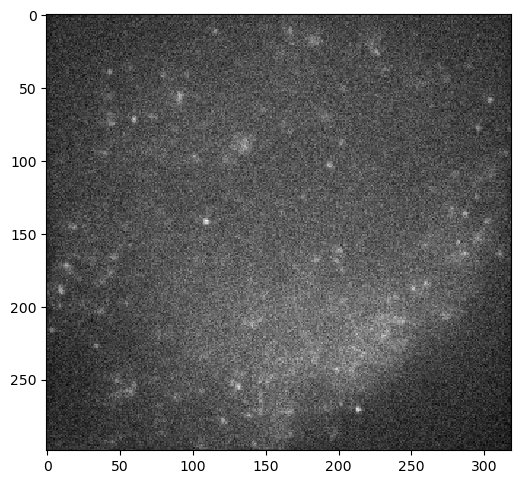

In [6]:
import storm_analysis.sa_library.datareader as datareader

frame = datareader.inferReader(image_data).loadAFrame(5).astype(numpy.float64)

pyplot.figure(figsize = (6, 6))
pyplot.imshow(frame, interpolation = 'nearest', cmap = "gray")
pyplot.show()

### Load movie and calculate mean and variance for each pixel

In [7]:
def calcMeanVar(movie_name):
    with dataReader.inferReader(movie_name) as dr:
        [w,h,l] = dr.filmSize()
        if(l>200):
            l = 200
        n = numpy.zeros((h,w), dtype = numpy.int64)
        nn = numpy.zeros((h,w), dtype = numpy.int64)
        for i in range(l):
            im = dr.loadAFrame(i)
            im = im.astype(numpy.int64)
            n = n + im
            nn = nn + im*im
        
    mean = n/float(l)
    var = nn/float(l) - mean*mean
    
    return [mean, var]


In [8]:
[mean, var] = calcMeanVar(image_data)

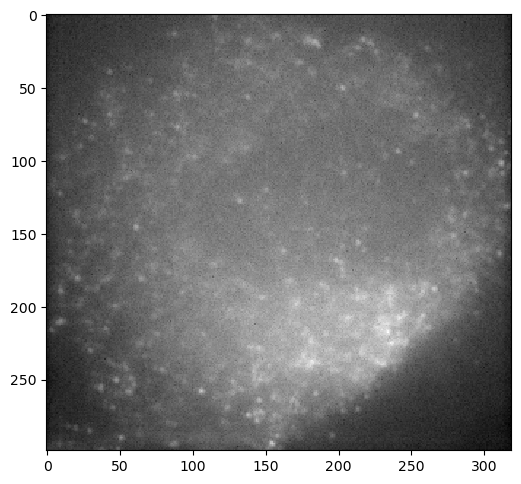

In [9]:
pyplot.figure(figsize = (6, 6))
pyplot.imshow(mean, interpolation = 'nearest', cmap = "gray")
pyplot.show()

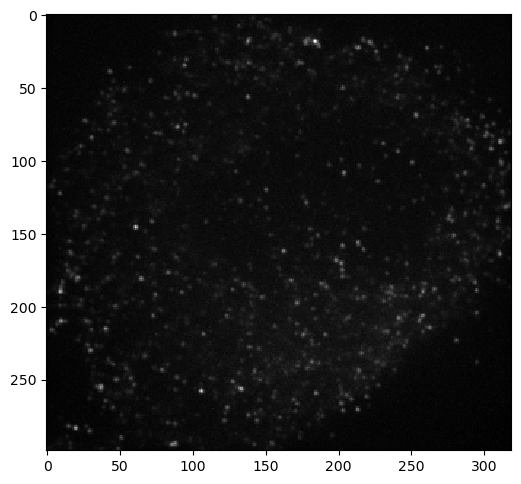

In [10]:
pyplot.figure(figsize = (6, 6))
pyplot.imshow(var, interpolation = 'nearest', cmap = "gray")
pyplot.show()

### Plot data with estimated fit

In this case we know what the actual camera values are so we can just use them. In general the easiest approach is to do the fit by eye, adjusting the gain and offset values to give you a line that goes through the cluster of points at the bottom of the mean vs variance graph. In Kothe et al. the authors estimated the fit using the [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) algorithm.

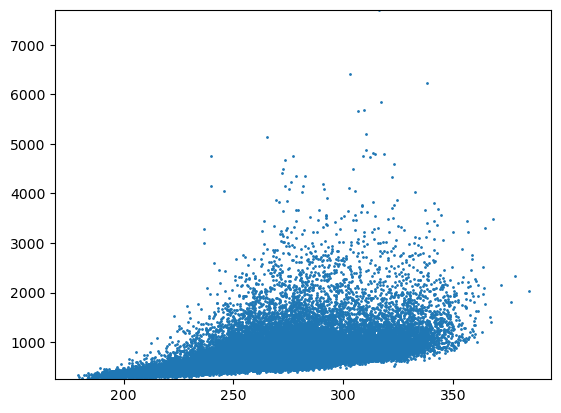

In [11]:
import numpy as np
# You may have to adjust these depending on your data.
x_max = np.max(mean)
x_min = np.min(mean)

x = numpy.array([x_min, x_max])

# In this function 100.0 is the offset and 2.0 is the camera gain.
y = (x - 100.0)*1.0
    
pyplot.scatter(mean,var,s=1)
#pyplot.plot(x,y,color = "black")
#pyplot.xlim(x_min,x_max)

# You may have to adjust the y range depending on your data.
y_max = np.max(var)
y_min = np.min(var)
pyplot.ylim([y_min, y_max])
pyplot.show()
    

In [12]:
from sklearn import datasets, linear_model

In [17]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(mean.flatten().reshape(-1, 1), var.flatten())
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [18]:
ransac.estimator_.coef_

array([3.83736727])

In [30]:
1/0.27

3.7037037037037033

In [26]:
X = mean.flatten().reshape(-1, 1)
y = var.flatten()
# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_X)

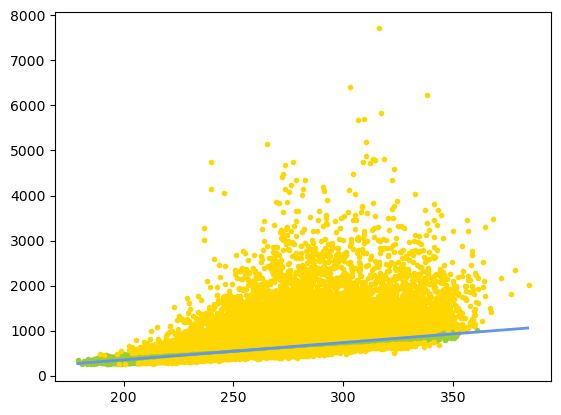

In [27]:
import matplotlib.pyplot as plt
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=2,
    label="RANSAC regressor",
)